# Assignment 2

Please enter your **name, surname** and **student number** instead of `"NAME-HERE"`, `"SURNAME-HERE"`, `"NUMBER-HERE"` below

In [4]:
student = {
    'name' : "Çağrı" ,
    'surname' : "Ertem", 
    'studentNumber' : "2360626"
}

print(student)

{'name': 'Çağrı', 'surname': 'Ertem', 'studentNumber': '2360626'}


In this assignment you will implement depth-first, iterative deepening and A* search algorithms. You will use these algoritms for a goal-based problem solving agent that navigates in a maze. 

## Maze

The mazes will be defined using a multi-line string as follows. Note that multiline strings in python are defined by triple quotes `"""`. 

In a maze string:
- `A` will represent the initial state of the agent
- `B` will represent the goal state
- `#` will represent the inaccessible locatoins (walls) that cannot be passed through by the agent
- ` ` will represent spaces (corridors) that can be passed through by the agent.

For example the following string

~~~~python
mazemap1 = """
#####B#
##### #
####  #
#### ##
     ##
A######
"""
~~~~
is equivalent to the maze picture below.

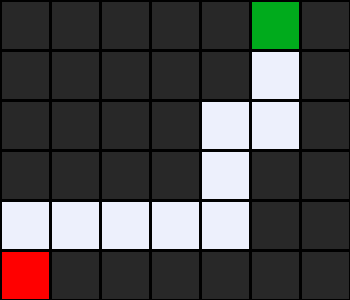

Alternatively you can define a maze in a separate text file by using the same rules and read that text file.

When you define a maze make sure that every line is composed of `#`, ` `, `A`, or `B`, and has the same number of characters)

*Note: This maze example has been adapted from Harvard Open Courseware*

#### Problem Class
Below we define the class of our problem:


In [5]:
class Maze:
    def __init__(self, mazemap=None, filename=None):

        if mazemap is not None:
            # Read the maze from a multiline string
            contents = mazemap.strip("\n")
        elif filename is not None:
            # Read the maze from a text file
            with open(filename) as f:
                contents = f.read()
        else:
            raise Exception(
                "Maze must be provided either as a multiline string with mazemap argument or in a text file with filename argument"
            )

        # Validate start and goal
        if contents.count("A") != 1:
            raise Exception("maze must have exactly one start point")
        if contents.count("B") != 1:
            raise Exception("maze must have exactly one goal")

        # Determine height and width of maze
        contents = contents.splitlines()
        self.height = len(contents)
        self.width = max(len(line) for line in contents)

        # Keep track of walls
        self.walls = []
        for i in range(self.height):
            row = []
            for j in range(self.width):
                try:
                    if contents[i][j] == "A":
                        self.initial = (i, j)
                        row.append(False)
                    elif contents[i][j] == "B":
                        self.goal = (i, j)
                        row.append(False)
                    elif contents[i][j] == " ":
                        row.append(False)
                    else:
                        row.append(True)
                except IndexError:
                    row.append(False)
            self.walls.append(row)

        self.solution = None

    def goal_test(self, state):
        return self.goal == state

    def action_cost(self, state1, action, state2):
        return 1

    def actions(self, state):
        row, col = state
        candidates = [
            ("up", (row - 1, col)),
            ("down", (row + 1, col)),
            ("left", (row, col - 1)),
            ("right", (row, col + 1)),
        ]

        moves = []
        for action, (r, c) in candidates:
            if 0 <= r < self.height and 0 <= c < self.width and not self.walls[r][c]:
                moves.append(action)
        return moves

    def result(self, state, action):
        row, col = state

        if action == "up":
            row -= 1
        elif action == "left":
            col -= 1
        elif action == "right":
            col += 1
        elif action == "down":
            row += 1
        return (row, col)

    def get_solution(self, node):
        if not self.goal_test(node.state):
            raise Exception("This node does not include a sollution.")
        actions = []
        cells = []
        while node.parent is not None:
            actions.append(node.action)
            cells.append(node.state)
            node = node.parent
        actions.reverse()
        cells.reverse()
        self.solution = (actions, cells)
        return self.solution

    def output_image(self, filename=None, show_solution=True, show_explored=False):
        from PIL import Image, ImageDraw
        from matplotlib import pyplot

        cell_size = 50
        cell_border = 2

        # Create a blank canvas
        img = Image.new(
            "RGBA", (self.width * cell_size, self.height * cell_size), "black"
        )
        draw = ImageDraw.Draw(img)

        solution = self.solution[1] if self.solution is not None else None
        for i, row in enumerate(self.walls):
            for j, col in enumerate(row):

                # Walls
                if col:
                    fill = (40, 40, 40)

                # Start
                elif (i, j) == self.initial:
                    fill = (255, 0, 0)

                # Goal
                elif (i, j) == self.goal:
                    fill = (0, 171, 28)

                # Solution
                elif solution is not None and show_solution and (i, j) in solution:
                    fill = (220, 235, 113)

                # Explored
                elif solution is not None and show_explored and (i, j) in self.explored:
                    fill = (212, 97, 85)

                # Empty cell
                else:
                    fill = (237, 240, 252)

                # Draw cell
                draw.rectangle(
                    (
                        [
                            (j * cell_size + cell_border, i * cell_size + cell_border),
                            (
                                (j + 1) * cell_size - cell_border,
                                (i + 1) * cell_size - cell_border,
                            ),
                        ]
                    ),
                    fill=fill,
                )
        pyplot.imshow(img)

        if filename is not None:
            img.save(filename)

Lets define a map environment using this problem class below

In [6]:
mazemap1 = """
#####B#
##### #
####  #
#### ##
     ##
A######
"""

In [7]:
maze1 = Maze(mazemap1)

You can draw an image of the maze environment as follows:

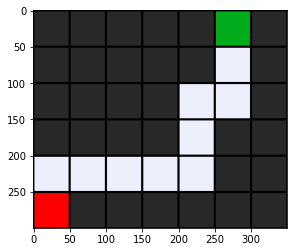

In [8]:
maze1.output_image()

The state of the environment are defined by a tuple containing `(row, column)` indices where the top-left cell is `(0,0)`. For example the initial state is the red point `(5,0)`

In [9]:
maze1.initial

(5, 0)

The goal state is the green cell which is `(0,5)` 

In [10]:
maze1.goal

(0, 5)

Possible actions are:
- `up`
- `down` 
- `left` 
- `right`
but of course not every action can be made in every step.
`actions` method returns the allowable actions in a state. For example, you can either go `down` or `right` in `(4,0)`.

In [11]:
maze1.actions((4,0))

['down', 'right']

`result` method is the transition model which returns the resulting state when you make an action in a given state. For example, if you move `'right'` in `(4,0)` you end up in `(4,1)`

In [12]:
maze1.result((4,0),'right')

(4, 1)

`goal_test` method will take in a state and return `True` if that state is the goal state.

In [13]:
maze1.goal_test((4,0))

False

In [14]:
maze1.goal_test((0,5))

True

Finally, `get_solution` method will take in a `Node` and if that `Node` belongs to solution will compute the actions and states that lead to a solution. Once you call `get_solution` with a solution, the `output_image` method will display the solution in red colour. Currently we have not found a solution, so `output_image` does not show it.

## Node and `expand()`
Below are some functions that you may be useful when implementing your search algorithms
- **Node**: The node data structure for the search tree.
- **expand()**: Function for expanding the nodes in the frontier.

In [15]:
class Node:
    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost
        if parent:
            self.depth = parent.depth + 1
        else:
            self.depth = 0

In [16]:
def expand(problem, node):
    s = node.state
    nodes = []
    for action in problem.actions(s):
        child_state = problem.result(s, action)
        cost = node.path_cost + problem.action_cost(s, action, child_state)
        yield Node(child_state, node, action, cost)

## Other mazes for the assignment
Below two other maze environments apart from `maze1` is available to test your model. Test your algorithms with `maze1` first as this is the simplest maze.

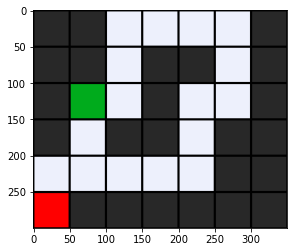

In [17]:
mazemap2 = """
##    #
## ## #
#B #  #
# ## ##
     ##
A######
"""
maze2 = Maze(mazemap2)
maze2.output_image()

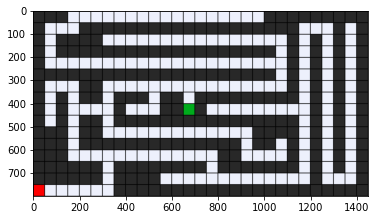

In [18]:
mazemap3 = """
###                 #########
#   ###################   # #
# ####                # # # #
# ################### # # # #
#                     # # # #
##################### # # # #
#   ##                # # # #
# # ## ### ## ######### # # #
# #    #   ##B#         # # #
# # ## ################ # # #
### ##             #### # # #
### ############## ## # # # #
###             ##    # # # #
###### ######## ####### # # #
###### ####             #   #
A      ######################
"""
maze3 = Maze(mazemap3)
maze3.output_image()

## Tasks

### a) Depth-First Search (25)

Implement the depth-first search algorithm for the problem. Run the algorithm for the three maze problems above and report **path_cost**, **nodes_expanded**, **max_search_depth**, **max_frontier_nodes** and **running_time** for the solution (check homework for more information). You can implement an additional function to gather these parameters and print them in a readable format. Show the solution as well preferably using `output_image`.


In [109]:
import queue as Q
L = Q.LifoQueue()

def dfs3(problem):
    frontier = Q.LifoQueue()
    start = Node(problem.initial)
    frontier.put(start)
    explored = {start.state: start}
    
    # Number of states explored
    num_explored = 0
    # Number of nodes expanded
    nodes_expanded = 0
    # Max search depth
    max_search_depth = 1
    # Max frontier number
    max_frontier_nodes = 1
    
    while True:
        if frontier.empty():
            raise Exception("could not be solved")
        
        node = frontier.get()
        num_explored += 1
        
        if problem.goal_test(node.state):
            print("Solved! Number of states explored: {}".format(num_explored))
            print("Number of nodes expanded: {}".format(nodes_expanded))
            print("Max Search Depth: {}".format(max_search_depth))
            #print("Path Cost: {}".format(Node.path_cost))
            print("Max Frontier Nodes: {}".format(max_frontier_nodes))
            return node
        
        for child in expand(problem, node):
            if child.state not in explored:
                frontier.put(child)
                explored[child.state] = child
    
        # Number of nodes expanded
        if node.parent:
                nodes_expanded += 1
                
        # Max search depth        
        if node.depth > max_search_depth:
            max_search_depth = node.depth

In [110]:
maze1.get_solution(dfs3(maze1))

Solved! Number of states explored: 11
Number of nodes expanded: 9
Max Search Depth: 9
Max Frontier Nodes: 1


(['up', 'right', 'right', 'right', 'right', 'up', 'up', 'right', 'up', 'up'],
 [(4, 0),
  (4, 1),
  (4, 2),
  (4, 3),
  (4, 4),
  (3, 4),
  (2, 4),
  (2, 5),
  (1, 5),
  (0, 5)])

In [111]:
dfs3(maze1)

Solved! Number of states explored: 11
Number of nodes expanded: 9
Max Search Depth: 9
Max Frontier Nodes: 1


In [112]:
%time res = dfs3(maze1)

Solved! Number of states explored: 11
Number of nodes expanded: 9
Max Search Depth: 9
Max Frontier Nodes: 1
CPU times: user 462 µs, sys: 47 µs, total: 509 µs
Wall time: 473 µs


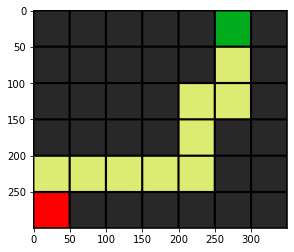

In [113]:
maze1.output_image()

In [114]:
maze2.get_solution(dfs3(maze2))

Solved! Number of states explored: 17
Number of nodes expanded: 15
Max Search Depth: 15
Max Frontier Nodes: 1


(['up',
  'right',
  'right',
  'right',
  'right',
  'up',
  'up',
  'right',
  'up',
  'up',
  'left',
  'left',
  'left',
  'down',
  'down',
  'left'],
 [(4, 0),
  (4, 1),
  (4, 2),
  (4, 3),
  (4, 4),
  (3, 4),
  (2, 4),
  (2, 5),
  (1, 5),
  (0, 5),
  (0, 4),
  (0, 3),
  (0, 2),
  (1, 2),
  (2, 2),
  (2, 1)])

In [115]:
dfs3(maze2)

Solved! Number of states explored: 17
Number of nodes expanded: 15
Max Search Depth: 15
Max Frontier Nodes: 1


In [116]:
%time res = dfs3(maze2)

Solved! Number of states explored: 17
Number of nodes expanded: 15
Max Search Depth: 15
Max Frontier Nodes: 1
CPU times: user 792 µs, sys: 111 µs, total: 903 µs
Wall time: 807 µs


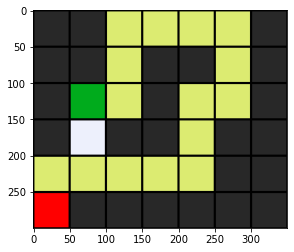

In [117]:
maze2.output_image()

In [118]:
maze3.get_solution(dfs3(maze3))

Solved! Number of states explored: 194
Number of nodes expanded: 192
Max Search Depth: 80
Max Frontier Nodes: 1


(['right',
  'right',
  'right',
  'right',
  'right',
  'right',
  'up',
  'up',
  'up',
  'left',
  'left',
  'left',
  'up',
  'up',
  'up',
  'up',
  'right',
  'right',
  'right',
  'up',
  'up',
  'right',
  'right',
  'right',
  'right',
  'right',
  'right',
  'right',
  'down',
  'down'],
 [(15, 1),
  (15, 2),
  (15, 3),
  (15, 4),
  (15, 5),
  (15, 6),
  (14, 6),
  (13, 6),
  (12, 6),
  (12, 5),
  (12, 4),
  (12, 3),
  (11, 3),
  (10, 3),
  (9, 3),
  (8, 3),
  (8, 4),
  (8, 5),
  (8, 6),
  (7, 6),
  (6, 6),
  (6, 7),
  (6, 8),
  (6, 9),
  (6, 10),
  (6, 11),
  (6, 12),
  (6, 13),
  (7, 13),
  (8, 13)])

In [119]:
dfs3(maze3)

Solved! Number of states explored: 194
Number of nodes expanded: 192
Max Search Depth: 80
Max Frontier Nodes: 1


In [120]:
%time res = dfs3(maze3)

Solved! Number of states explored: 194
Number of nodes expanded: 192
Max Search Depth: 80
Max Frontier Nodes: 1
CPU times: user 6.73 ms, sys: 1.39 ms, total: 8.12 ms
Wall time: 7 ms


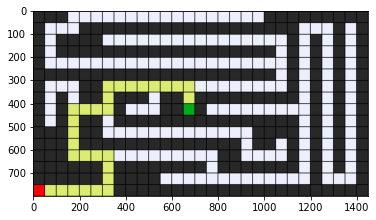

In [121]:
maze3.output_image()

### b) Iterative Deepening Depth-Limited Search (15)

Implement the iterative deepening depth-limited search algorithm for the problem. Run the algorithm for the three maze problems above, and report the same statistics and solution described in question a) above. 

In [242]:
import queue as Q

def ids(problem):
    frontier = Q.Queue()
    start = Node(problem.initial)
    frontier.put(start)
    explored = {start.state: start}
    
    # Number of states explored
    num_explored = 0
    # Number of nodes expanded
    nodes_expanded = 0
    # Max search depth
    max_search_depth = 1
    # Max frontier nodes
    max_frontier_nodes = 1
    
    while True:
        if frontier.empty():
            raise Exception("could not be solved")
            
        node = frontier.get()
        num_explored += 1 
        
        # Number of nodes expanded
        if node.parent:
            nodes_expanded += 1
            
        # Max search depth        
        if node.depth > max_search_depth:
            max_search_depth = node.depth    
        
        if problem.goal_test(node.state):
            print("Solved! Number of states explored: {}".format(num_explored))
            print("Number of nodes expanded: {}".format(nodes_expanded))
            print("Max Search Depth: {}".format(max_search_depth))
            #print("Path Cost: {}".format(Node.path_cost))
            print("Max Frontier Nodes: {}".format(max_frontier_nodes))
            return node
                
        for child in expand(problem, node): 
            if child.state not in explored:
                frontier.put(child)
                explored[child.state] = child
                
        if frontier.empty():
            frontier.put(start)
            depth_limit += 1
            explored = {start.state: start} 

In [243]:
maze1.get_solution(ids(maze1))

Solved! Number of states explored: 11
Number of nodes expanded: 10
Max Search Depth: 10
Max Frontier Nodes: 1


(['up', 'right', 'right', 'right', 'right', 'up', 'up', 'right', 'up', 'up'],
 [(4, 0),
  (4, 1),
  (4, 2),
  (4, 3),
  (4, 4),
  (3, 4),
  (2, 4),
  (2, 5),
  (1, 5),
  (0, 5)])

In [244]:
ids(maze1)

Solved! Number of states explored: 11
Number of nodes expanded: 10
Max Search Depth: 10
Max Frontier Nodes: 1


In [245]:
%time res = ids(maze1)

Solved! Number of states explored: 11
Number of nodes expanded: 10
Max Search Depth: 10
Max Frontier Nodes: 1
CPU times: user 569 µs, sys: 97 µs, total: 666 µs
Wall time: 616 µs


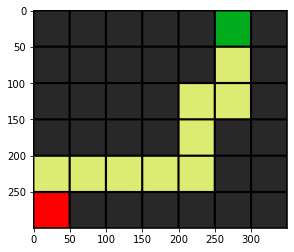

In [246]:
maze1.output_image()

In [247]:
maze2.get_solution(ids(maze2))

Solved! Number of states explored: 6
Number of nodes expanded: 5
Max Search Depth: 4
Max Frontier Nodes: 1


(['up', 'right', 'up', 'up'], [(4, 0), (4, 1), (3, 1), (2, 1)])

In [248]:
ids(maze2)

Solved! Number of states explored: 6
Number of nodes expanded: 5
Max Search Depth: 4
Max Frontier Nodes: 1


In [249]:
%time res = ids(maze2)

Solved! Number of states explored: 6
Number of nodes expanded: 5
Max Search Depth: 4
Max Frontier Nodes: 1
CPU times: user 334 µs, sys: 53 µs, total: 387 µs
Wall time: 343 µs


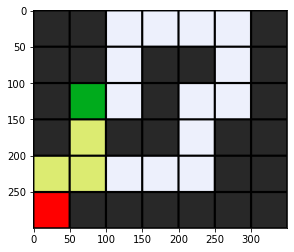

In [250]:
maze2.output_image()

In [251]:
maze3.get_solution(ids(maze3))

Solved! Number of states explored: 77
Number of nodes expanded: 76
Max Search Depth: 30
Max Frontier Nodes: 1


(['right',
  'right',
  'right',
  'right',
  'right',
  'right',
  'up',
  'up',
  'up',
  'left',
  'left',
  'left',
  'up',
  'up',
  'up',
  'up',
  'right',
  'right',
  'right',
  'up',
  'up',
  'right',
  'right',
  'right',
  'right',
  'right',
  'right',
  'right',
  'down',
  'down'],
 [(15, 1),
  (15, 2),
  (15, 3),
  (15, 4),
  (15, 5),
  (15, 6),
  (14, 6),
  (13, 6),
  (12, 6),
  (12, 5),
  (12, 4),
  (12, 3),
  (11, 3),
  (10, 3),
  (9, 3),
  (8, 3),
  (8, 4),
  (8, 5),
  (8, 6),
  (7, 6),
  (6, 6),
  (6, 7),
  (6, 8),
  (6, 9),
  (6, 10),
  (6, 11),
  (6, 12),
  (6, 13),
  (7, 13),
  (8, 13)])

In [252]:
ids(maze3)

Solved! Number of states explored: 77
Number of nodes expanded: 76
Max Search Depth: 30
Max Frontier Nodes: 1


In [253]:
%time res = ids(maze3)

Solved! Number of states explored: 77
Number of nodes expanded: 76
Max Search Depth: 30
Max Frontier Nodes: 1
CPU times: user 2.25 ms, sys: 131 µs, total: 2.38 ms
Wall time: 2.34 ms


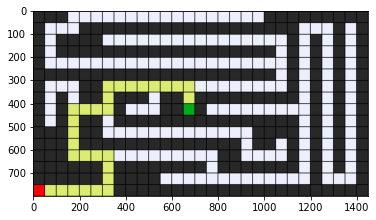

In [254]:
maze3.output_image()

### c) A* (60)

Implement the A* algorithm for the problem. Run A* algortihms with at least **two heuristics** for the three maze problems discussed above. Show the solutions of A* algorithms preferably by using `output_image`. Compare the results of these algorithms with each other and also with the algorithms you implemented in the previous sections using the same statistics as described in question a). Discuss these results.

In [229]:
import math
import queue as Q
L = Q.PriorityQueue

def heuristic1(goal_state, node_state):
    x = abs(goal_state[0] - node_state[0])
    y = abs(goal_state[1] - node_state[1])
    return x + y

def heuristic2(goal_state, node_state):
    x = abs(goal_state[0] - node_state[0])
    y = abs(goal_state[1] - node_state[1])
    return math.sqrt(x * x + y * y)

#A*/A*/A*#

def a_star(problem, heuristic = None):
    frontier = Q.PriorityQueue()
    start = Node(problem.initial)
    frontier.put(start, 0)    
    explored = {start.state: start}
     
    # Number of states explored
    num_explored = 0
    # Number of nodes expanded
    nodes_expanded = 0
    # Max search depth
    max_search_depth = 1
    # Max frontier nodes
    max_frontier_nodes = 1    
        
    while not frontier.empty():                
        node = frontier.get()
        
        # Number of nodes expanded
        if node.parent:
            nodes_expanded += 1
            
        # Max search depth        
        if node.depth > max_search_depth:
            max_search_depth = node.depth   
        
        if problem.goal_test(node.state):
            print("Solved! Number of states explored: {}".format(num_explored))
            print("Number of nodes expanded: {}".format(nodes_expanded))
            print("Max Search Depth: {}".format(max_search_depth))
            #print("Path Cost: {}".format(Node.path_cost))
            print("Max Frontier Nodes: {}".format(max_frontier_nodes))
            return node   
        
        for child in expand(problem, node):
            if child.state not in explored:
                    priority = child.path_cost + heuristic1(problem.goal, child.state) 
                    frontier.put(child, priority)
                    explored[child.state] = child

Solved! Number of states explored: 0
Number of nodes expanded: 10
Max Search Depth: 10
Max Frontier Nodes: 1
Solved! Number of states explored: 0
Number of nodes expanded: 10
Max Search Depth: 10
Max Frontier Nodes: 1
Solved! Number of states explored: 0
Number of nodes expanded: 10
Max Search Depth: 10
Max Frontier Nodes: 1
CPU times: user 612 µs, sys: 68 µs, total: 680 µs
Wall time: 622 µs


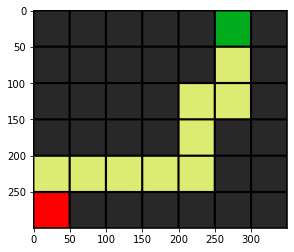

In [233]:
maze1.get_solution(a_star(maze1, heuristic1))
a_star(maze1, heuristic1)
%time res = a_star(maze1, heuristic1)
maze1.output_image()

In [237]:
maze1.get_solution(a_star(maze1, heuristic1))

Solved! Number of states explored: 0
Number of nodes expanded: 10
Max Search Depth: 10
Max Frontier Nodes: 1


(['up', 'right', 'right', 'right', 'right', 'up', 'up', 'right', 'up', 'up'],
 [(4, 0),
  (4, 1),
  (4, 2),
  (4, 3),
  (4, 4),
  (3, 4),
  (2, 4),
  (2, 5),
  (1, 5),
  (0, 5)])

In [239]:
maze2.get_solution(a_star(maze2, heuristic1))

TypeError: '<' not supported between instances of 'Node' and 'Node'

In [240]:
maze3.get_solution(a_star(maze3, heuristic1))

TypeError: '<' not supported between instances of 'Node' and 'Node'

In [262]:
print("To conclude, while the implementation of the first two algorithms, namely deep-first search and iterative deepening depth-limited search, was successful,  A* failed. As observed from our outputs, Ids gives better results than dfs3. Comparing to the dfs3, by using ids, we get lower results in terms of maximum search depth, number of nodes expanded, timing and number of states explored. Moreover, in the solution of the maze 2, dfs3 could not find the shortest path while ids could find. This shows the efficiency of ids over dfs3.")

To conclude, while the implementation of the first two algorithms, namely deep-first search and iterative deepening depth-limited search, was successful,  A* failed. As observed from our outputs, Ids gives better results than dfs3. Comparing to the dfs3, by using ids, we get lower results in terms of maximum search depth, number of nodes expanded, timing and number of states explored. Moreover, in the solution of the maze 2, dfs3 could not find the shortest path while ids could find. This shows the efficiency of ids over dfs3.
